### Objective

Use Python to read in an XYZ grid file in legacy ZMAP+ format as `numpy` array, display it with `matplotlib`, write it to a plain ASCII XYZ grid text file.
I will use the DEM data for Mount St. Helens BEFORE the 1980 eruption, taken from Evan's [excellent notebook](https://nbviewer.jupyter.org/github/agile-geoscience/notebooks/blob/master/Mt_St-Helens.ipynb), which I converted to ZMAP+ (that I wil l show you in another notebook).


As an aside, this notebook was my very, very first exposure to Python, and Jupyter, at a [pilot of Agile's Geocomputing course](https://agilescientific.com/blog/2014/5/6/how-much-rock-was-erupted-from-mt-st-helens.html)... so thanks Evan!

### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from linecache import getline
from matplotlib.mlab import griddata

### Import data

##### ZMAP plus files have a header that looks like this:

! -----------------------------------------

! ZMap ASCII grid file

! 

! -----------------------------------------

@unnamed HEADER, GRID, 5

15, 1E+030, , 7, 1

468, 327, 0, 326, 0, 467

0. , 0. , 0.

@

##### The rows starting with `!` are comments, we will want to ignore them
##### We need, from the section between the two `@`s (the actual header):
- the second entry in its second line -  the null value
- the first two entries in its third line - the number of rows and columns, respectively
- the last four entries in its third line - the xmin, xmax, ymin, ymax, respectively.

__NB my first approach was to assume a constant number of comment rows to pick only the ones with the bits needed:__

In [2]:
filename = '../data/Helens_before_XYZ_ZMAP_PLUS.dat'

In [3]:
header6 = getline(filename, 6)
header7 = getline(filename, 7)

In [4]:
if header6.split(',')[1].strip(' ') == '': null=np.nan
else: null = float(header6.split(',')[1].strip(' '))

In [5]:
xmin, xmax, ymin, ymax = [ float(x) for x in header7.split(",")[2::]]

In [6]:
grid_rows = int(header7.split(",")[0])
grid_cols = int(header7.split(",")[1])

In [7]:
print(null, xmin, xmax, ymin, ymax, grid_rows, grid_cols)

1e+30 0.0 326.0 0.0 467.0 468 327


__That worked, but what if the number of  commented rows changed?__

My second approach, below, is more generic, and uses:

- an  `if` statement to check for the line beginning with `@` (usually followed by a  grid name) but not `@\n`; then grab the next two lines
- another `if` statement to check whether a line starts with `!`
- a counter is increased by one for each line meeting either of the above conditions. This is used later on to skip all lines that do not have data.

I think there is room to come back and write something more efficient later on, but for now I am satisfied.

In [8]:
count = 0
hdr=[]
with open(filename) as h:
    for line in h:
        if line.startswith('!'): 
            count += 1
        if line.startswith('@') and not line.startswith('@\n'):
            count += 1
            hdr.append(next(h)); count += 1
            hdr.append(next(h)); count += 1
            count += 1               

In [9]:
hdr

['15, 1E+030, , 7, 1\n', '468, 327, 0, 326, 0, 467\n']

In [10]:
hdr = [x.strip('\n') for x in ','.join(hdr).split(',')]

In [11]:
hdr

['15', ' 1E+030', ' ', ' 7', ' 1', '468', ' 327', ' 0', ' 326', ' 0', ' 467']

In [12]:
if hdr[1] ==' ': null=np.nan
else: null = float(hdr[1]) 

In [13]:
xmin, xmax, ymin, ymax = [ float(x) for x in hdr[7:11]]

In [14]:
grid_rows, grid_cols = [int(y) for y in hdr[5:7]]

In [15]:
print(null, xmin, xmax, ymin, ymax, grid_rows, grid_cols)

1e+30 0.0 326.0 0.0 467.0 468 327


### Read in the data

__NB.  Now comes the tricky part because data is aranged in 327 blocks (the grid rows) and each block has 466 elements (the grid columns). But each row in the file has 5 elements (you can check by uncommenting the commands in the cell below), and since 466/5 has a remainder of 1, there is a row with just 1 elemnt at the ennd of each block, which makes using `np.loadtext` or even `np.genromtxt` not practical (at least I could not).__

In [16]:
#header5 = getline(f, 5)
#ncols = header5.split(",")[-1]
#print(ncols)

##### Below, the first loop skips the 9 header lines, second loop reads all elements in a single array.

In [17]:
with open(filename) as f:
    [next(f) for _ in range(count)]                
    for line in f:
        grid = (np.asarray([word for line in f for word in line.split()]).astype(float)).reshape(grid_cols, grid_rows).T

grid[grid==null]=np.nan

### Plot just to be sure we got what we wanted

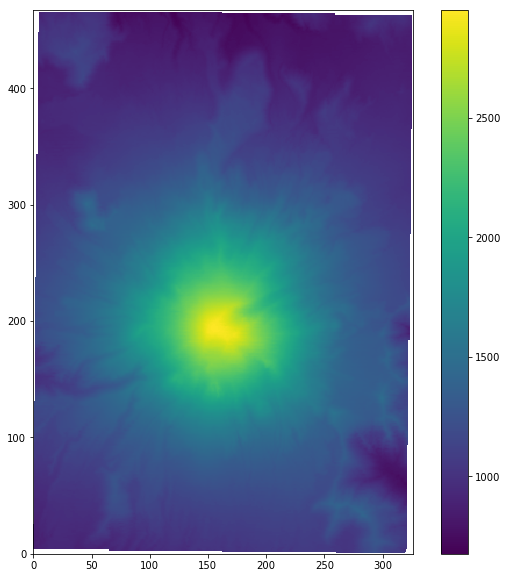

In [18]:
plt.figure (figsize=(10, 10))
plt.imshow(grid, extent=[xmin, xmax, ymin, ymax])
plt.colorbar();
plt.savefig('Helens_before_plt.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

### Export to plain XYZ columnar ASCII file

##### Spacing is 30 for both X and Y but let's not assume it!

In [19]:
xi = np.arange(xmin, xmax + (xmax-xmin)/(grid_cols-1),  (xmax-xmin)/(grid_cols-1))
yi = np.arange(ymin, ymax + (xmax-xmin)/(grid_cols-1),  (ymax-ymin)/(grid_rows-1))
X, Y = np.meshgrid(xi,yi)

In [20]:
outname = '../data/Helens_before_XYZ_plain_ASCII.txt'

In [21]:
np.savetxt(outname, np.stack((X.flatten(), Y.flatten(), grid.flatten()), axis=-1),  fmt = '%.2f',delimiter=',')